# 가설: CCTV가 많으면 범죄검거율이 높을 것이다? 
5대 강력범죄(살인, 강도, 절도, 강간강제추행, 폭력)만 고려함. 
(서울특별시 2018년도 데이터 사용)

In [1]:
# 1. 라이브러리 호출
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
import json

# 2. 시각화 설정
from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

# 3. 한글폰트를 설정(한글을 사용한다면 반드시해야 함)
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 4. 해상도
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
# 5. 데이터 파일 불러오기
df_crime = pd.read_excel('data/서울시_5대_범죄_발생현황_통계.xlsx')
df_cctv = pd.read_excel('data/서울시 자치구 년도별 CCTV 설치 현황(2011년 이전_2018년.xlsx')
df_seoul = pd.read_excel('data/서울시_행정구역(구별)_통계.xlsx')
df_pop = pd.read_csv('data/자치구단위 서울 생활인구 일별 집계표.csv', encoding = 'cp949')
geo_path = f'data/seoul_municipalities_geo_simple.json'

In [3]:
# 6. 데이터 전처리

# 6-1. 서울시 자치구별 범죄통계 데이터 전처리 함수
def crime_processing(df):
    columns = ['자치구','합계','총검거수']
    df = df[columns].copy()
    df = df.drop(0).copy()
    df = df.drop(1).copy()
    df = df.set_index('자치구').copy()
    df['검거율'] = df['총검거수']/df['합계'] *100
    
    return df

# 6-2. 서울시 자치구별 인구수 데이터 전처리 함수
def pop_processing(df):
    col = ['기준일ID', '총생활인구수', '시군구명']
    df = df[col].copy()
    df = df[df['기준일ID']==20180405].copy()
    df = df.reset_index()
    df = df.drop(0).copy()
    df = df.set_index('시군구명').copy()
    return df



# 6-3. 서울시 자치구별 면적 데이터 전처리 함수
def seoul_processing(df):
    df=df.drop(0).copy()
    df=df.drop(1).copy()
    df['면적'] = pd.to_numeric(df['면적'])
    df = df.set_index('자치구').copy()
    return df
seoul_data = seoul_processing(df_seoul).copy()
seoul_data

# 6-4. 서울시 자치구별 CCTV수 데이터 전처리 함수
def cctv_processing(df):
    df['소계'] = pd.to_numeric(df['소계'])
    
    col_list = []
    for i in df_cctv.index:
        col_list.append(df_cctv.loc[i]['기관명'])
    n = 0
    col_list2 = []
    for gu in col_list:
        name = gu.replace(' ', '')
        col_list2.append(name)
        n += 1
        
    df['자치구'] = col_list2
    df = df.set_index('자치구').copy()
    return df

geo_json = json.load(open(geo_path, encoding="utf-8"))
geo_json['features'][0]['properties']['name']

pd.options.display.float_format = '{:.5f}'.format #유효숫자 설정

In [4]:
crime_data = crime_processing(df_crime).copy()
pop_data = pop_processing(df_pop).copy()
seoul_data = seoul_processing(df_seoul).copy()
cctv_data = cctv_processing(df_cctv).copy()

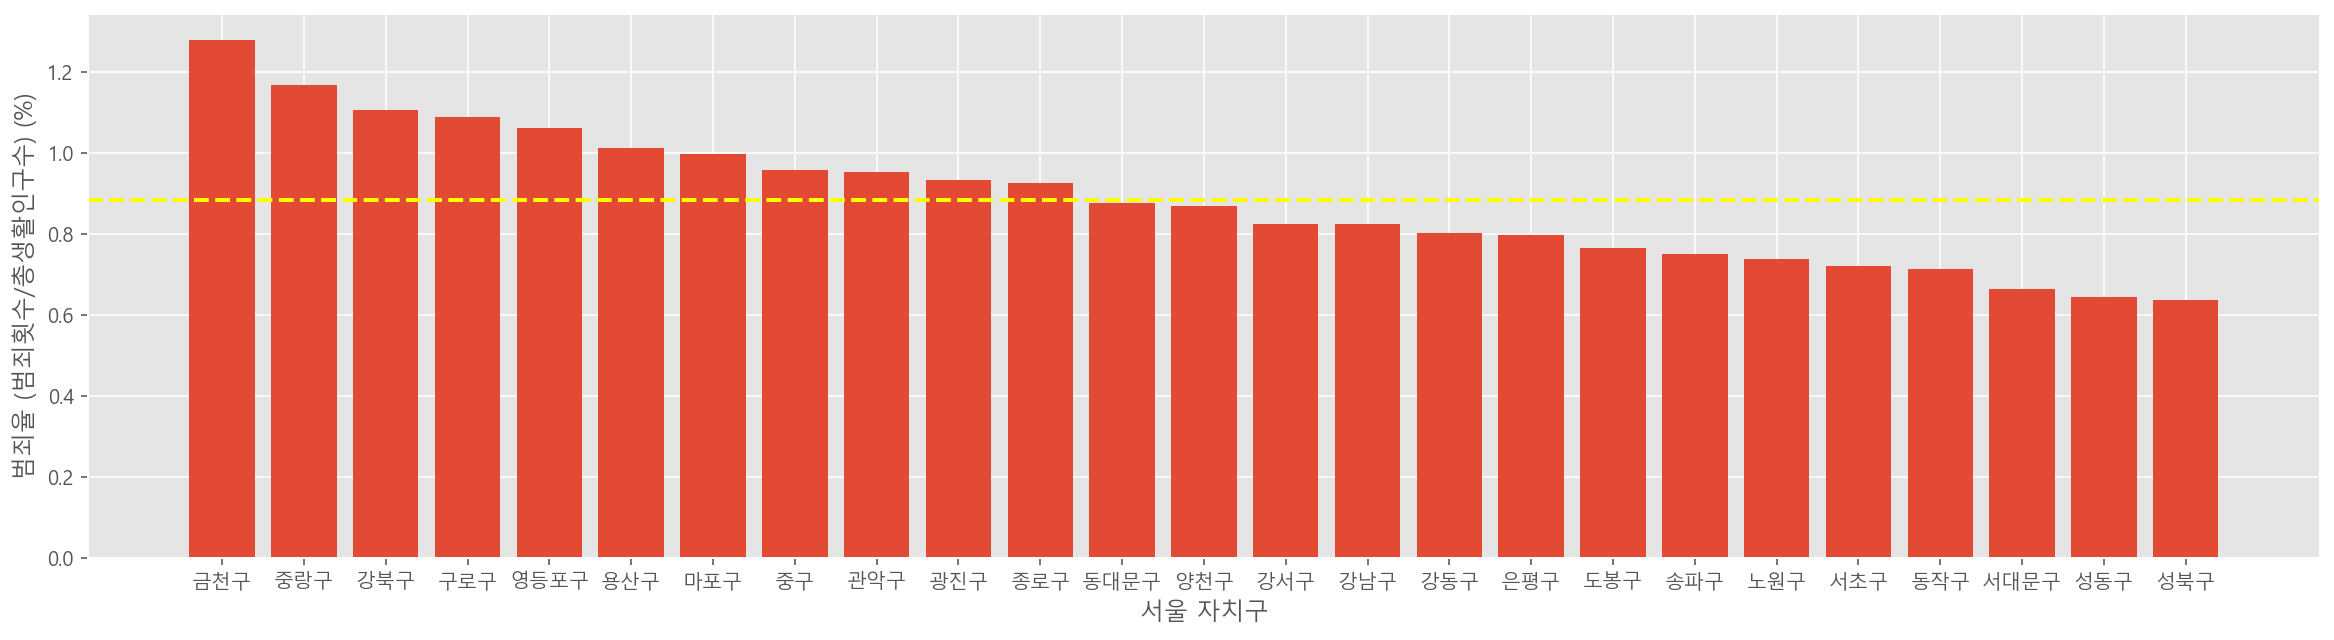

In [5]:
#7.데이터 시각화
#7-1. 자치구별 범죄율 데이터 시각화
crime_data['범죄율'] = crime_data['합계']/pop_data['총생활인구수']*100

crime_data = crime_data.sort_values(by='범죄율', ascending=False).copy()

plt.figure(figsize=(20,5))

plt.bar(crime_data.index, crime_data['범죄율'])
plt.xlabel('서울 자치구')
plt.ylabel('범죄율 (범죄횟수/총생활인구수) (%)')
plt.axhline(y=crime_data['범죄율'].mean(), color='yellow', linestyle='--', linewidth=2)

plt.show();

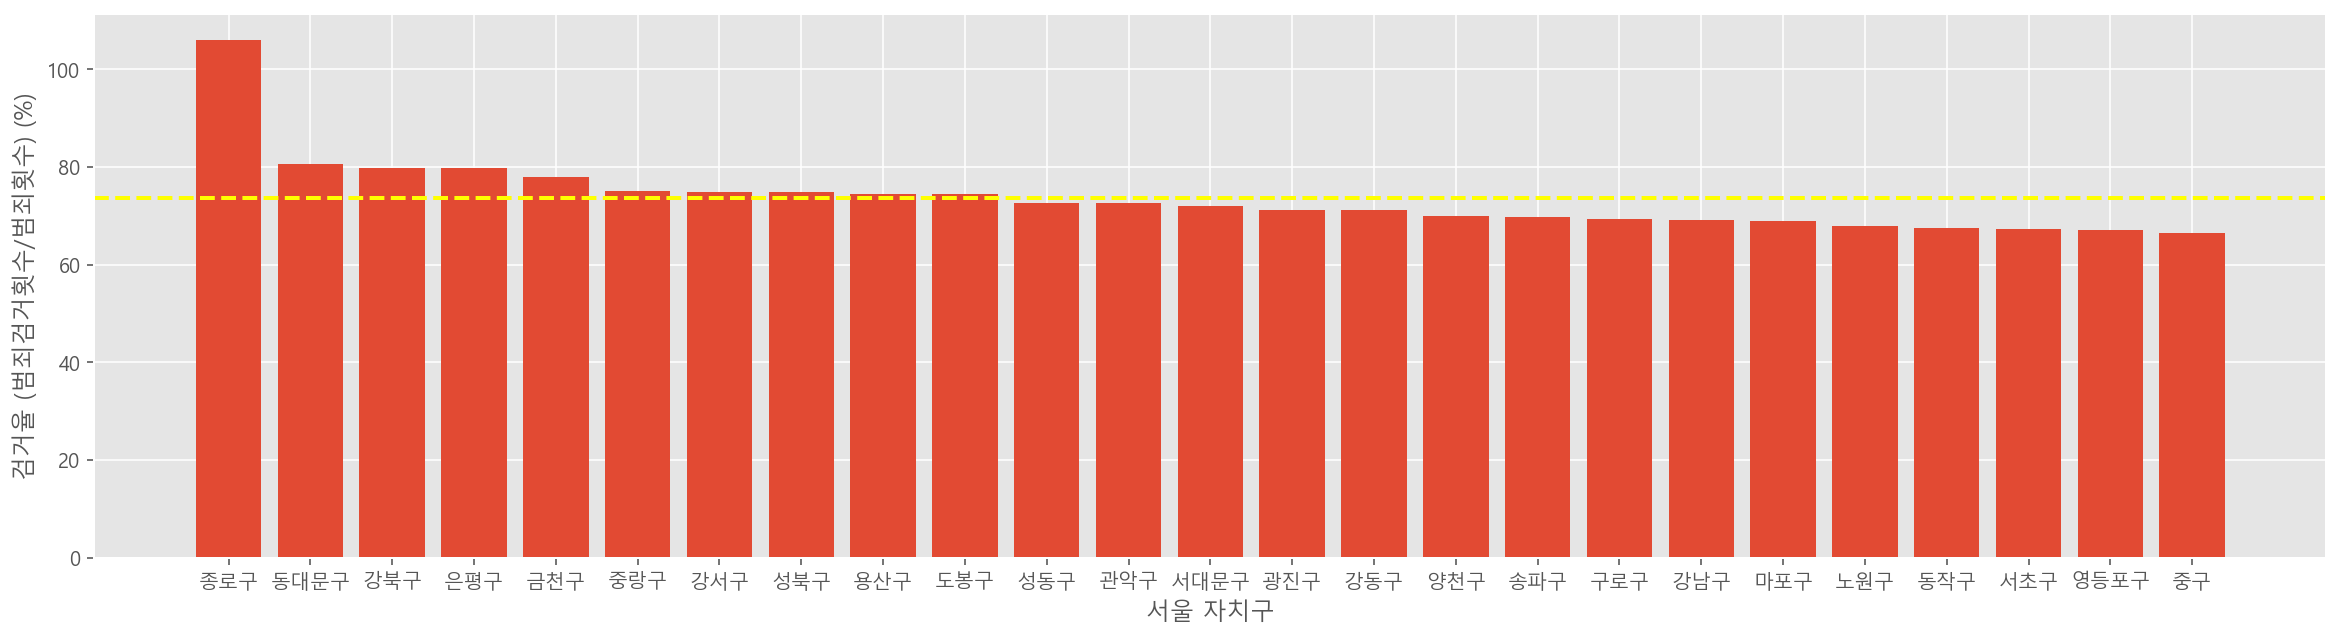

In [6]:
#7-2. 자치구별 범죄검거율 데이터 시각화
crime_data = crime_data.sort_values(by='검거율', ascending=False).copy()

plt.figure(figsize=(20,5))

plt.bar(crime_data.index, crime_data['검거율'])
plt.xlabel('서울 자치구')
plt.ylabel('검거율 (범죄검거횟수/범죄횟수) (%)')
plt.axhline(y=crime_data['검거율'].mean(), color='yellow', linestyle='--', linewidth=2)

plt.show();

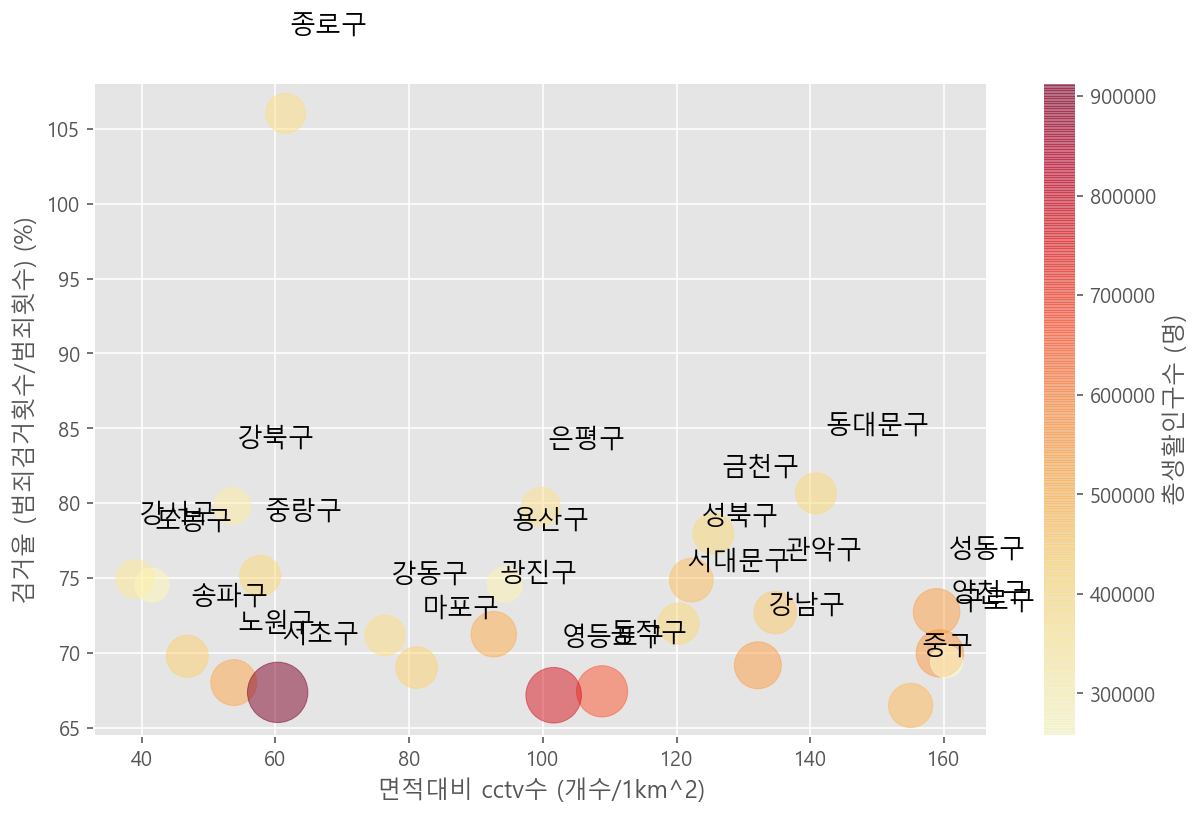

In [7]:
#7-3. 면적대비 cctv수와 검거율의 상관관계 도식화
crime_data['면적대비 cctv수'] = cctv_data['소계'] / seoul_data['면적'].copy()
crime_data['생활인구수'] = pop_data['총생활인구수'].copy()
crime_data['면적당 생활인구수'] = crime_data['생활인구수']/seoul_data['면적'].copy()

plt.figure(figsize=(10, 6))
plt.scatter(crime_data['면적대비 cctv수'], crime_data['검거율'], c=pop_data['총생활인구수'], s=pop_data['총생활인구수']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('면적대비 cctv수 (개수/1km^2)')
plt.ylabel('검거율 (범죄검거횟수/범죄횟수) (%)')

for name in crime_data.index:
    plt.text(crime_data['면적대비 cctv수'][name]*1.01, crime_data['검거율'][name]*1.05, name, fontsize=13)

plt.colorbar(label='총생활인구수 (명)')
plt.show()

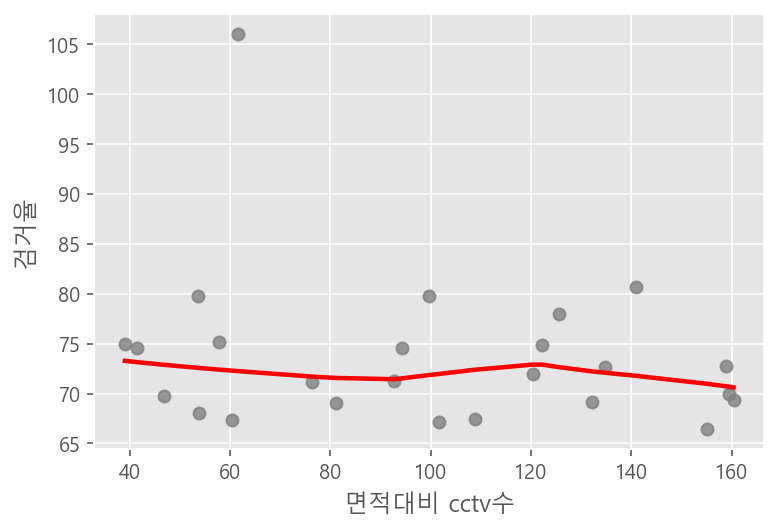

In [8]:
sns.regplot(x='면적대비 cctv수', y='검거율', lowess=True, data=crime_data,
            line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})

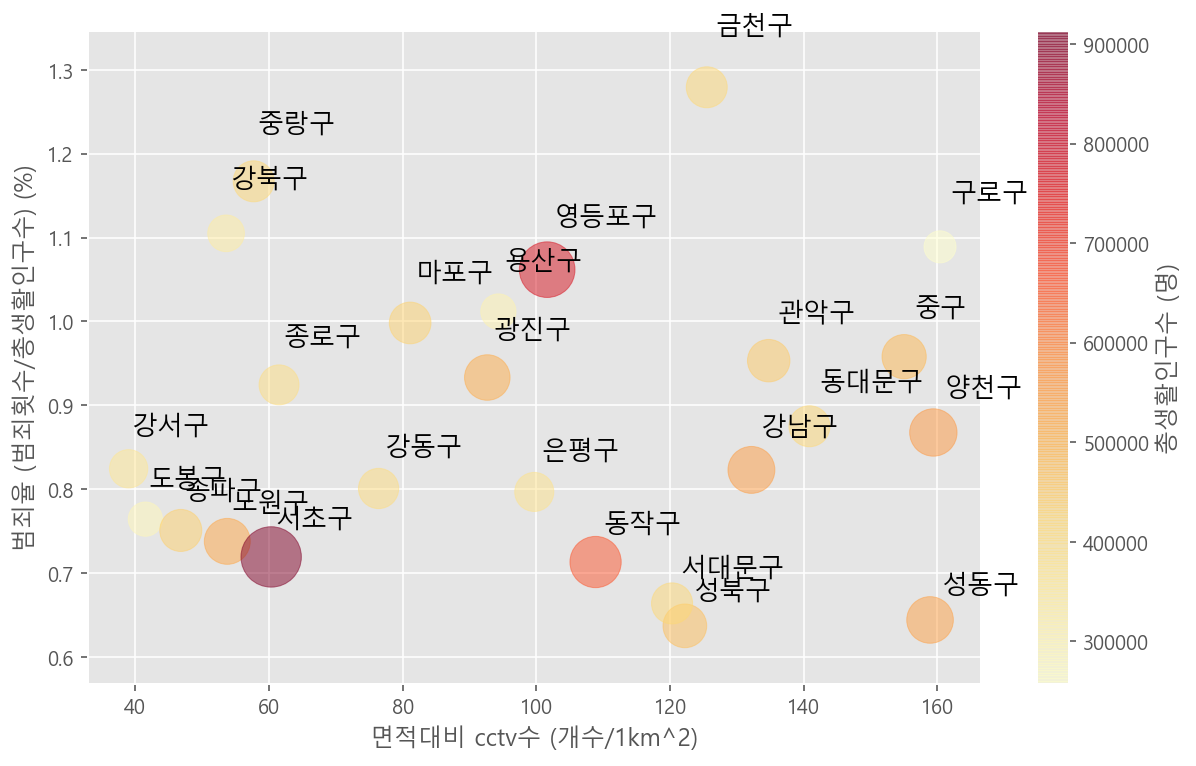

In [9]:
#7-4. 면적대비 cctv수와 범죄율의 상관관계 도식화
plt.figure(figsize=(10, 6))
plt.scatter(crime_data['면적대비 cctv수'], crime_data['범죄율'], c=pop_data['총생활인구수'], s=pop_data['총생활인구수']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('면적대비 cctv수 (개수/1km^2)')
plt.ylabel('범죄율 (범죄횟수/총생활인구수) (%)')
for name in crime_data.index:
    plt.text(crime_data['면적대비 cctv수'][name]*1.01, crime_data['범죄율'][name]*1.05, name, fontsize=13)

plt.colorbar(label='총생활인구수 (명)')
plt.show()

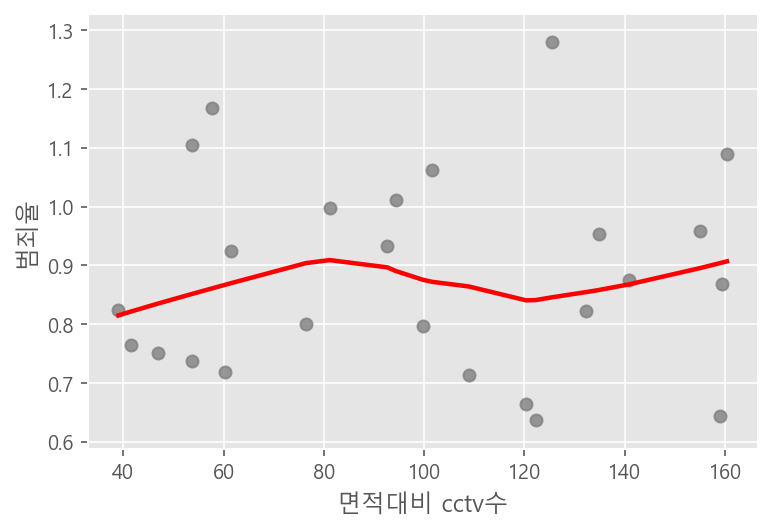

In [10]:
sns.regplot(x='면적대비 cctv수', y='범죄율', lowess=True, data=crime_data,
            line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})

# 면적당 CCTV의 수는 범죄율과는 약한 상관관계를 보이지만 범죄검거율과는 상관관계를 보이지 않는다.
CCTV의 밀도는 범죄검거율에는 큰 영향을 주진 않지만 범죄를 예방하는 효과를 보인다.
오류를 줄이고자 각 자치구별 생활인구밀도를 고려한 범죄율과 면적 당 CCTV의 수의 상관관계를 탐색해보기로 하였다.

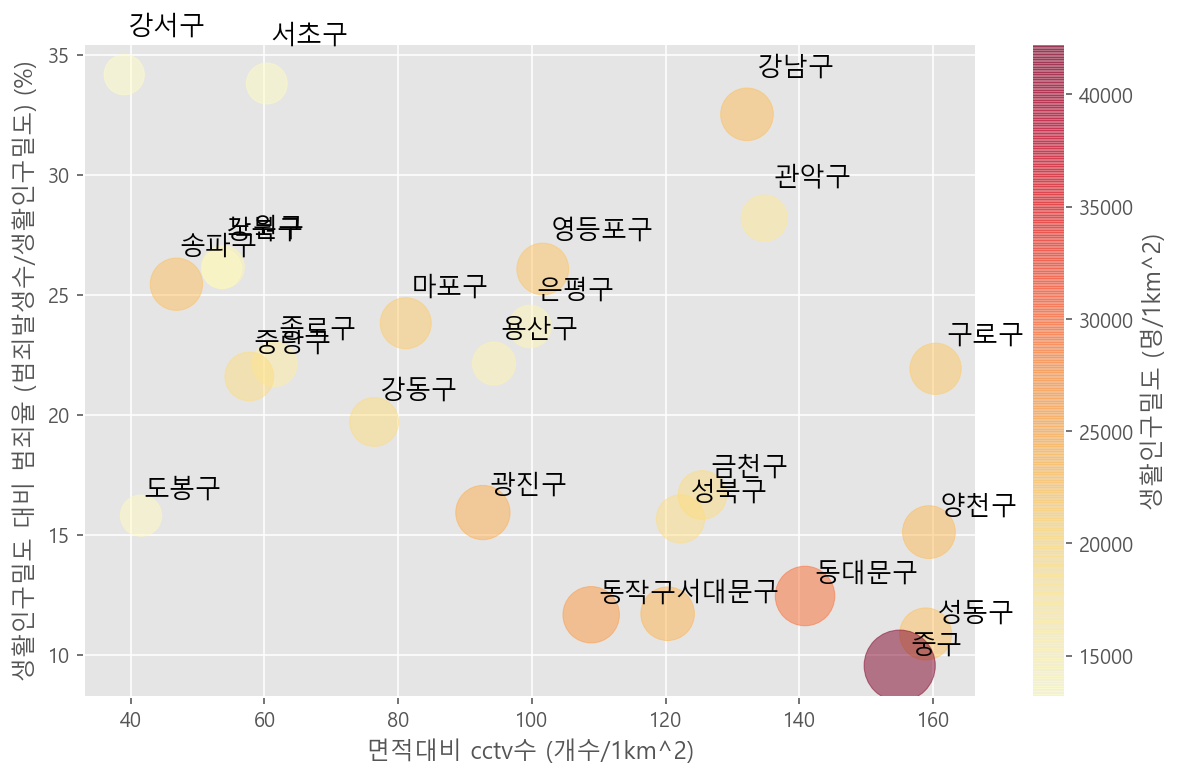

In [11]:
#7-3. 면적대비 cctv수와 생활인구밀도 대비 범죄율의 상관관계 도식화

crime_data['면적당 생활인구수'] = crime_data['생활인구수']/seoul_data['면적'].copy()
crime_data['생활인구밀도대비_범죄율'] = crime_data['합계']/crime_data['면적당 생활인구수'] *100

plt.figure(figsize=(10, 6))
plt.scatter(crime_data['면적대비 cctv수'], crime_data['생활인구밀도대비_범죄율'], c=crime_data['면적당 생활인구수'], s=crime_data['면적당 생활인구수']*0.03, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('면적대비 cctv수 (개수/1km^2)')
plt.ylabel('생활인구밀도 대비 범죄율 (범죄발생수/생활인구밀도) (%)')
for name in crime_data.index:
    plt.text(crime_data['면적대비 cctv수'][name]*1.01, crime_data['생활인구밀도대비_범죄율'][name]*1.05, name, fontsize=13)

plt.colorbar(label='생활인구밀도 (명/1km^2)')
plt.show()

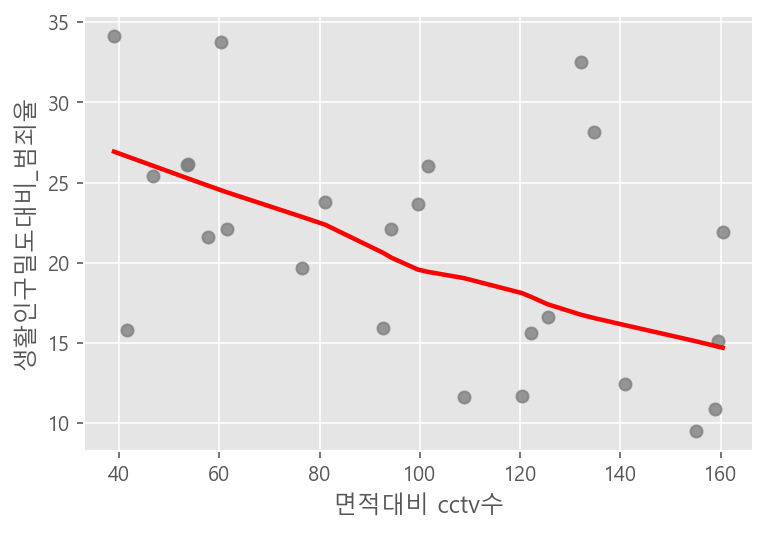

In [12]:
sns.regplot(x='면적대비 cctv수', y='생활인구밀도대비_범죄율', lowess=True, data=crime_data,
            line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})

In [13]:
#7-4 면적당 cctv 수 지도 시각화

m = folium.Map([37.5366518765642, 126.99356706692662], zoom_start=11, tiles='stamen toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=crime_data,
    columns=[crime_data.index, '면적대비 cctv수'],
    key_on='feature.properties.name',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='면적대비 cctv수'
).add_to(m)

In [14]:
m.save('cctv_density.html')

In [15]:
#7-5 인구밀도 대비 범죄 발생 수 지도 시각화

m2 = folium.Map([37.5366518765642, 126.99356706692662], zoom_start=11, tiles='stamen toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=crime_data,
    columns=[crime_data.index, '생활인구밀도대비_범죄율'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='생활인구밀도대비_범죄율'
).add_to(m2)

m2.save('PopDensity_crime.html')

# 결론: 동일 면적 내 CCTV의 수가 많으면 인구밀도 대비 범죄 발생이 줄어든다.

자치구 내 CCTV의 밀도는 자치구 내 범죄검거율에는 큰 영향을 주진 않지만 범죄를 사전에 예방하는 효과를 보인다.

*아웃라이어 분석
1. 도봉구: 면적내 산지가 많아 면적대비 cctv수가 적게 측정된 것으로 보임.
2. 관악구, 강남구: 원룸 및 유흥시설 등이 밀집된 특징때문에 인구밀도 대비 높은 범죄율을 보임.